# CoPro: a data-driven modelling framework for conflict risk projections

## Authors

- Jannis M. Hoch (Utrecht University, j.m.hoch@uu.nl)
- Sophie de Bruin (PBL Netherlands Environmental Assessment Agency)
- Niko Wanders (Utrecht University)

# Setup

## Library import

In [1]:
import copro

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import seaborn as sns
import os, sys
import warnings
import click
warnings.simplefilter("ignore")

In [2]:
copro.utils.show_versions()

Python version: 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]
copro version: 0.0.8
geopandas version: 0.9.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
scikit-learn version: 0.23.2
matplotlib version: 3.2.1
seaborn version: 0.11.0
rasterstats version: 0.14.0


# Parameter definitions

All parameters required to run CoPro have to be specified in file which can be parsed by ConfigParser.

In [3]:
SETTINGS_FILE = r'../example/example_settings.cfg'

In [4]:
click.echo(click.style(open(SETTINGS_FILE, 'r').read(), fg='blue'))

[general]
input_dir=./example_data
output_dir=./OUT
# 1: all data; 2: leave-one-out model; 3: single variable model; 4: dubbelsteenmodel
# Note that only 1 supports sensitivity_analysis
model=1
verbose=True

[settings]
# start year
y_start=2000
# end year
y_end=2012

[PROJ_files]
# cfg-files
proj_nr_1=./example_settings_proj.cfg

[pre_calc]
# if nothing is specified, the XY array will be stored in output_dir
# if XY already pre-calculated, then provide path to npy-file
XY=

[extent]
shp=waterProvinces/waterProvinces_Africa_eliminatedPolysLE20000km2.shp

[conflict]
# either specify path to file or state 'download' to download latest PRIO/UCDP dataset
conflict_file=UCDP/ged201.csv
min_nr_casualties=1
# 1=state-based armed conflict; 2=non-state conflict; 3=one-sided violence
type_of_violence=1,2,3

[climate]
shp=KoeppenGeiger/2000/Koeppen_Geiger_1976-2000.shp
# define either one or more classes (use abbreviations!) or specify nothing for not filtering
zones=BWh,BSh
code2class=KoeppenGeige

The only parameter than can be set here is the verbosity of the model. If it is set, it supersedes the setting in the cfg-file.

In [5]:
VERBOSE = False

In [6]:
main_dict, root_dir = copro.utils.initiate_setup(SETTINGS_FILE, verbose=VERBOSE)


#### CoPro version 0.0.8 ####
#### For information about the model, please visit https://copro.readthedocs.io/ ####
#### Copyright (2020-2021): Jannis M. Hoch, Sophie de Bruin, Niko Wanders ####
#### Contact via: j.m.hoch@uu.nl ####
#### The model can be used and shared under the MIT license ####

INFO: reading model properties from ../example/example_settings.cfg
INFO: verbose mode on: False
INFO: saving output to main folder C:\Users\hoch0001\Documents\_code\copro\example\./OUT


In `main_dict`, the output directories as well as parsed config-objects are stored and can be retrieved throughout the simulation.

In [9]:
main_dict

{'_REF': [<configparser.RawConfigParser at 0x28953d9dc08>,
  'C:\\Users\\hoch0001\\Documents\\_code\\copro\\example\\./OUT\\_REF'],
 'proj_nr_1': [[<configparser.RawConfigParser at 0x28953da10c8>],
  'C:\\Users\\hoch0001\\Documents\\_code\\copro\\example\\./OUT\\_PROJ\\proj_nr_1']}

# Data import

In [10]:
conflict_gdf, selected_polygons_gdf, global_df = copro.selection.select(main_dict['_REF'][0], 
                                                                                    main_dict['_REF'][1], 
                                                                                    root_dir)

INFO: reading csv file to dataframe C:\Users\hoch0001\Documents\_code\copro\example\./example_data\UCDP/ged201.csv
INFO: filtering based on conflict properties.


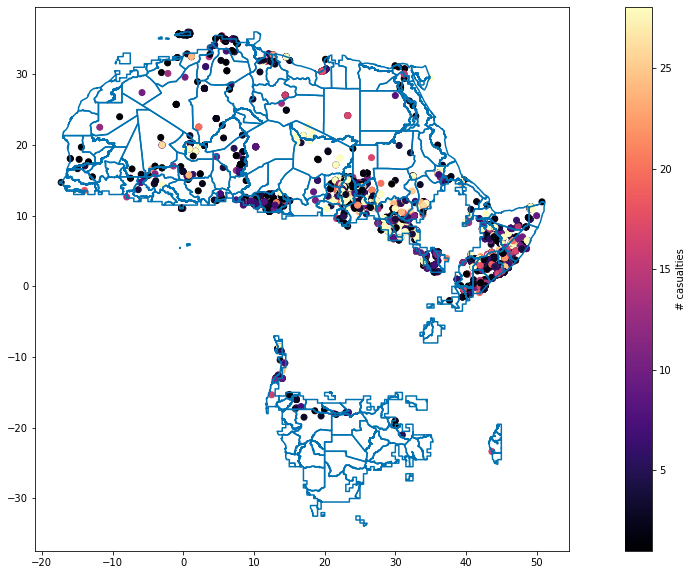

In [11]:
fig, ax= plt.subplots(1, 1, figsize=(20,10))
conflict_gdf.plot(ax=ax, c='r', column='best', cmap='magma', 
                  vmin=int(main_dict['_REF'][0].get('conflict', 'min_nr_casualties')), vmax=conflict_gdf.best.mean(), 
                  legend=True, 
                  legend_kwds={'label': "# casualties", 'orientation': "vertical", 'pad': 0.05})
selected_polygons_gdf.boundary.plot(ax=ax);

# Data processing and analysis

In [12]:
X, Y = copro.pipeline.create_XY(main_dict['_REF'][0], main_dict['_REF'][1], root_dir, selected_polygons_gdf, conflict_gdf)

INFO: reading data for period from 2000 to 2012
INFO: skipping first year 2000 to start up model
INFO: entering year 2001
INFO: entering year 2002
INFO: entering year 2003
INFO: entering year 2004
INFO: entering year 2005
INFO: entering year 2006
INFO: entering year 2007
INFO: entering year 2008
INFO: entering year 2009
INFO: entering year 2010
INFO: entering year 2011
INFO: entering year 2012


In [13]:
scaler, clf = copro.pipeline.prepare_ML(main_dict['_REF'][0])

In [14]:
scaler

QuantileTransformer(random_state=42)

In [15]:
clf

RandomForestClassifier(class_weight={1: 100}, n_estimators=1000,
                       random_state=42)

In [16]:
out_X_df = copro.evaluation.init_out_df()
out_y_df = copro.evaluation.init_out_df()
out_dict = copro.evaluation.init_out_dict()
trps, aucs, mean_fpr = copro.evaluation.init_out_ROC_curve()

INFO: run 1 of 10


No handles with labels found to put in legend.


INFO: run 2 of 10


No handles with labels found to put in legend.


INFO: run 3 of 10


No handles with labels found to put in legend.


INFO: run 4 of 10


No handles with labels found to put in legend.


INFO: run 5 of 10


No handles with labels found to put in legend.


INFO: run 6 of 10


No handles with labels found to put in legend.


INFO: run 7 of 10


No handles with labels found to put in legend.


INFO: run 8 of 10


No handles with labels found to put in legend.


INFO: run 9 of 10


No handles with labels found to put in legend.


INFO: run 10 of 10


No handles with labels found to put in legend.


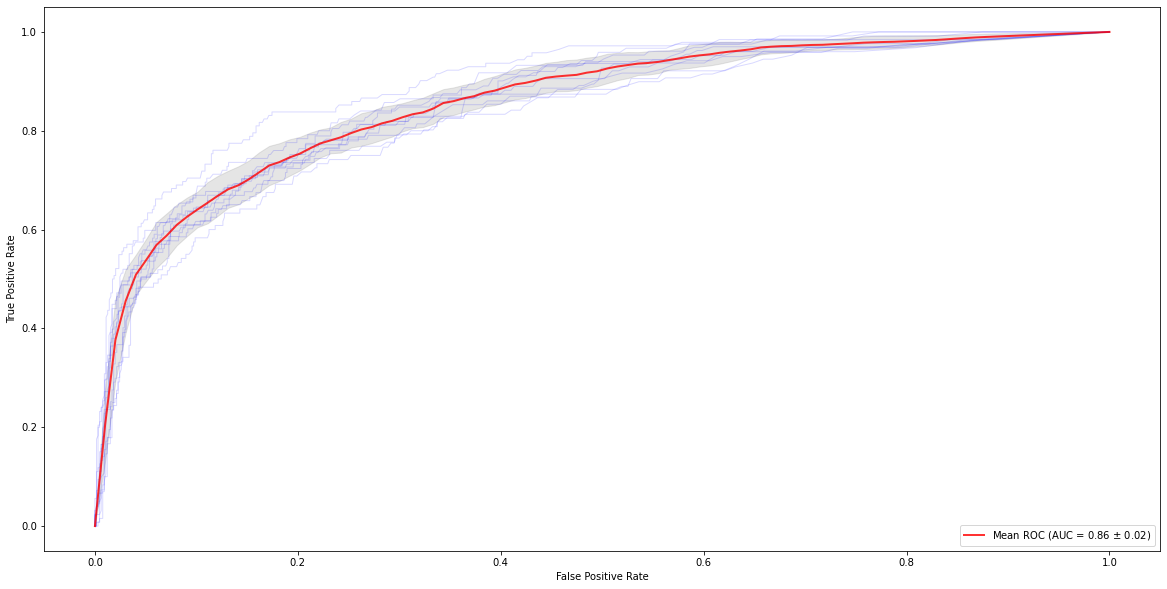

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))

#- go through all n model executions
for n in range(main_dict['_REF'][0].getint('machine_learning', 'n_runs')):
    
    print('INFO: run {} of {}'.format(n+1, main_dict['_REF'][0].getint('machine_learning', 'n_runs')))

    #- run machine learning model and return outputs
    X_df, y_df, eval_dict = copro.pipeline.run_reference(X, Y, main_dict['_REF'][0], scaler, clf, main_dict['_REF'][1], run_nr=n+1)
    
    #- select sub-dataset with only datapoints with observed conflicts
    X1_df, y1_df = copro.utils.get_conflict_datapoints_only(X_df, y_df)
    
    #- append per model execution
    out_X_df = copro.evaluation.fill_out_df(out_X_df, X_df)
    out_y_df = copro.evaluation.fill_out_df(out_y_df, y_df)
    out_dict = copro.evaluation.fill_out_dict(out_dict, eval_dict)

    #- plot ROC curve per model execution
    tprs, aucs = copro.plots.plot_ROC_curve_n_times(ax, clf, X_df.to_numpy(), y_df.y_test.to_list(),
                                                                  trps, aucs, mean_fpr)

#- plot mean ROC curve
copro.plots.plot_ROC_curve_n_mean(ax, tprs, aucs, mean_fpr)

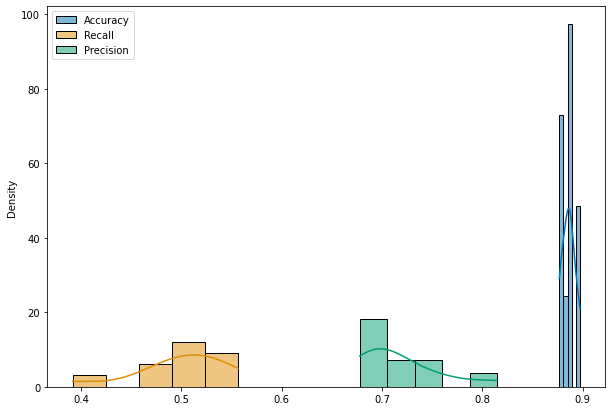

In [19]:
copro.plots.metrics_distribution(out_dict, metrics=['Accuracy', 'Recall', 'Precision'], figsize=(10, 7));

In [20]:
df_hit, gdf_hit = copro.evaluation.polygon_model_accuracy(out_y_df, global_df)

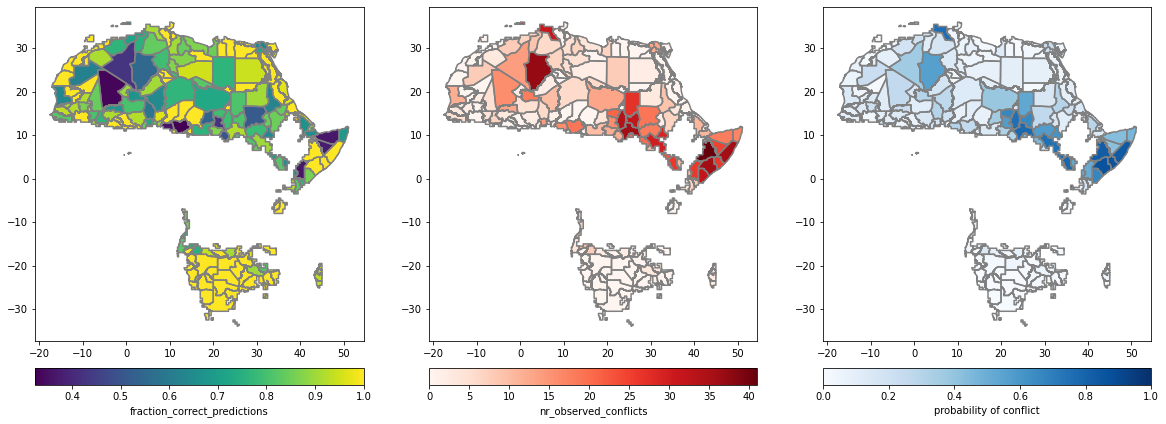

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
gdf_hit.plot(ax=ax1, column='fraction_correct_predictions', legend=True, 
             legend_kwds={'label': "fraction_correct_predictions", 'orientation': "horizontal", 'pad':0.05})
selected_polygons_gdf.boundary.plot(ax=ax1, color='0.5')
gdf_hit.plot(ax=ax2, column='nr_observed_conflicts', legend=True, cmap='Reds', 
             legend_kwds={'label': "nr_observed_conflicts", 'orientation': "horizontal", 'pad':0.05})
selected_polygons_gdf.boundary.plot(ax=ax2, color='0.5')
gdf_hit.plot(ax=ax3, column='probability_of_conflict', legend=True, cmap='Blues', vmin=0, vmax=1, 
             legend_kwds={'label': "probability of conflict", 'orientation': "horizontal", 'pad':0.05})
selected_polygons_gdf.boundary.plot(ax=ax3, color='0.5');

In [22]:
feat_imp = copro.evaluation.get_feature_importance(clf, main_dict['_REF'][0], main_dict['_REF'][1])

In [37]:
feat_imp

,feature_importance
precipitation,0.314204
temperature,0.332652
gdp,0.286575
conflict_t_min_1,0.043957
conflict_t_min_1_nb,0.022612


In [24]:
all_y_df = copro.pipeline.run_prediction(scaler.fit(X[: , 2:]), main_dict, root_dir, selected_polygons_gdf)

INFO: loading config-object for projection run: proj_nr_1
INFO: the projection period is 2013 to 2015
INFO: making projection for year 2013
INFO: making projection for year 2014
INFO: making projection for year 2015
